In [1]:
from pathlib import Path
import numpy as np
import sys
import time
import warnings

warnings.simplefilter(action="ignore")

In [2]:
# __file__ = Path().cwd()
# repo_root = Path(__file__).resolve().parents[1] / "suite3d"
# print(repo_root)
# sys.path.insert(0, str(repo_root))

In [3]:
start = time.time()
from suite3d.job import Job

end = time.time()
print(f"Importing suite3d.job took {end - start:.2f} seconds")

Importing suite3d.job took 16.25 seconds


Loading job directory for move in D:\W2_DATA\kbarber\07_27_2025\mk355\suite3d_plane_alignment
Launching initial pass
Saving summary to D:\W2_DATA\kbarber\07_27_2025\mk355\suite3d_plane_alignment\s3d-move\summary\summary.npy
    Loaded file into shared memory in 0.95 sec
    Workers completed in 2.37 sec
    Total time: 3.33 sec
Initialization pass took 55.02 seconds


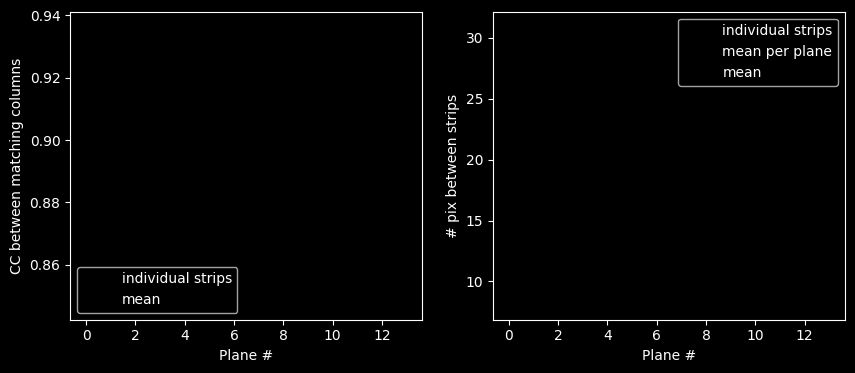

In [ ]:
from tqdm import tqdm
from time import sleep
import psutil

running = True

with (
    tqdm(total=100, desc="cpu%", position=1) as cpubar,
    tqdm(total=100, desc="ram%", position=0) as rambar,
):
    while running:
        fpath = Path(r"D:\W2_DATA\kbarber\07_27_2025\mk355\green")
        job_path = fpath.parent.joinpath("suite3d_plane_alignment")

        # Set the mandatory parameters
        params = {
            # volume rate
            "fs": 17,
            "planes": np.arange(14),
            "n_ch_tif": 14,
            "tau": 0.7,
            "lbm": True,
            "fuse_strips": True,
            "subtract_crosstalk": False,
            "init_n_frames": 500,
            "n_init_files": 1,
            "n_proc_corr": 15,
            "max_rigid_shift_pix": 150,
            "3d_reg": True,
            "gpu_reg": True,
            "block_size": [64, 64],
        }

        tifs = list(fpath.glob("*.tif*"))
        job = Job(
            str(job_path),
            "move",
            create=True,
            overwrite=True,
            verbosity=0,
            tifs=tifs,
            params=params,
        )

        start = time.time()
        job.run_init_pass()
        end = time.time()
        print(f"Initialization pass took {end - start:.2f} seconds")
        rambar.n = psutil.virtual_memory().percent
        cpubar.n = psutil.cpu_percent()
        rambar.refresh()
        cpubar.refresh()
        sleep(0.5)

In [5]:
summary = np.load(
    r"D:\W2_DATA\kbarber\07_27_2025\mk355\suite3d_plane_alignment\s3d-move\summary\summary.npy",
    allow_pickle=True,
).item()
shifts = summary["plane_shifts"]  # shape (n_planes, 2) [dy, dx]

In [6]:
shifts

array([[ 0,  0],
       [ 8, -1],
       [16, -2],
       [24, -3],
       [32, -3],
       [40, -3],
       [47, -4],
       [54, -5],
       [61, -6],
       [68, -7],
       [75, -7],
       [82, -7],
       [89, -7],
       [96, -7]])

In [8]:
!uv pip install nvidia-ml-py3

Using Python 3.12.9 environment at: C:\Users\RBO\repos\mbo_utilities\.venv
Resolved 1 package in 1.02s
   Building nvidia-ml-py3==7.352.0
      Built nvidia-ml-py3==7.352.0
Prepared 1 package in 1.75s
Installed 1 package in 3ms
 + nvidia-ml-py3==7.352.0



GPU %:   0%|          | 0/100 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.88 sec
    Workers completed in 2.03 sec
    Total time: 2.92 sec



GPU %:   7%|▋         | 7/100 [00:35<07:54,  5.11s/it]
RAM %:  32%|███▏      | 31.5/100 [00:35<01:17,  1.13s/it]
CPU %:  12%|█▏        | 12.4/100 [00:35<04:12,  2.88s/it]


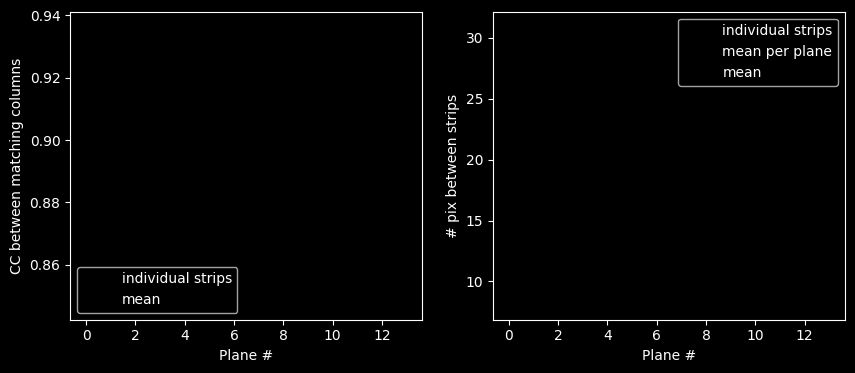

In [15]:
from pathlib import Path
import numpy as np
import time
import subprocess
import psutil
from tqdm import tqdm
from suite3d.job import Job


def get_gpu_usage():
    """
    Returns (gpu_util %, mem_util %) using nvidia-smi.
    """
    try:
        result = subprocess.check_output(
            [
                "nvidia-smi",
                "--query-gpu=utilization.gpu,memory.used,memory.total",
                "--format=csv,noheader,nounits",
            ],
            encoding="utf-8",
        )
        util, mem_used, mem_total = map(int, result.strip().split(","))
        mem_util = int(mem_used * 100 / mem_total)
        return util, mem_util
    except Exception:
        return 0, 0


fpath = Path(r"D:\W2_DATA\kbarber\07_27_2025\mk355\green")
job_path = fpath.parent.joinpath("suite3d_plane_alignment")

params = {
    "fs": 17,
    "planes": np.arange(14),
    "n_ch_tif": 14,
    "tau": 0.7,
    "lbm": True,
    "fuse_strips": True,
    "subtract_crosstalk": False,
    "init_n_frames": 500,
    "n_init_files": 1,
    "n_proc_corr": 15,
    "max_rigid_shift_pix": 150,
    "3d_reg": True,
    "gpu_reg": True,
    "block_size": [64, 64],
}

tifs = list(fpath.glob("*.tif*"))
job = Job(
    str(job_path),
    "move2",
    create=True,
    overwrite=True,
    verbosity=-1,
    tifs=tifs,
    params=params,
)

with (
    tqdm(total=100, desc="CPU %", position=2) as cpubar,
    tqdm(total=100, desc="RAM %", position=1) as rambar,
    tqdm(total=100, desc="GPU %", position=0) as gpubar,
):
    job.run_init_pass()  # replace with job.run() for full pipeline

    # Update bars one last time
    rambar.n = psutil.virtual_memory().percent
    cpubar.n = psutil.cpu_percent()
    gpu_util, mem_util = get_gpu_usage()
    gpubar.n = gpu_util
    rambar.refresh()
    cpubar.refresh()
    gpubar.refresh()

In [14]:
summary = np.load(
    r"D:\W2_DATA\kbarber\07_27_2025\mk355\suite3d_plane_alignment\s3d-move2\summary\summary.npy",
    allow_pickle=True,
).item()
shifts = summary["plane_shifts"]  # shape (n_planes, 2) [dy, dx]
shifts

array([[ 0,  0],
       [ 8, -1],
       [16, -2],
       [24, -3],
       [32, -3],
       [40, -3],
       [47, -4],
       [54, -5],
       [61, -6],
       [68, -7],
       [75, -7],
       [82, -7],
       [89, -7],
       [96, -7]])